# 布林通道實戰

## 交易邏輯

* 根據統計學的常態分佈理論，有 95.44% 的樣本都會位於正負兩個標準差這個區間，因此當股價超出這區間時，產生反轉的機率會大幅上升。
* 我們可以把移動平均、正二標準差、負二標準差，轉換成中軌、上軌、下軌

## 交易策略

* 當今天的收盤價觸碰到上軌且持有部位時，隔日賣出。
* 當今天的收盤價觸碰到下軌且現金部位大於零時，隔日買入。
* 當今天的收盤價觸碰到下軌、現金部位大於零且當日收盤價低於上次買入訊號收盤價時，隔日加碼一單位。

## 資料來源

[布林通道交易策略](https://www.tejwin.com/insight/%e5%b8%83%e6%9e%97%e9%80%9a%e9%81%93%e4%ba%a4%e6%98%93%e7%ad%96%e7%95%a5/)

## 編輯交易策略

### 載入所需套件與輸入資料

In [1]:
import pandas as pd 
import numpy as np 
import tejapi
import os 
import matplotlib.pyplot as plt

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'YOUR KEY'
os.environ['mdate'] = '20210401 20221231'
os.environ['ticker'] = '2409'

# 使用 ingest 將股價資料導入暫存，並且命名該股票組合 (bundle) 為 tquant
!zipline ingest -b tquant 

Merging daily equity files:
Currently used TEJ API key call quota 495/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 61089856/9223372036854775807 (0.0%)


[2024-02-07 03:24:48.623366] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-07 03:24:52.381719] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### 載入所需套件

In [2]:
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import BollingerBands
from zipline.pipeline.data import EquityPricing

### 建立 Pipeline 函式

`Pipeline()` 提供使用者快速處理多檔標的的量化指標與價量資料的功能，於本次案例我們用以處理:

* 過去 20 日布林通道上軌
* 過去 20 日布林通道中軌
* 過去 20 日布林通道下軌
* 當期收盤價

In [3]:
def make_pipeline():
    
    perf = BollingerBands(inputs=[EquityPricing.close], window_length=20, k=2)
    upper,middle,lower = perf.upper,perf.middle, perf.lower
    curr_price = EquityPricing.close.latest
     
    return Pipeline(
        columns = {
            'upper':  upper,
            'middle':  middle,
            'lower':  lower,
            'curr_price':curr_price
        }
    )

### 建立 initialize 函式

`inintialize` 函式用於定義交易開始前的每日交易環境，與此例中我們設置:

* 流動性滑價
* 交易手續費
* 買入持有友達的報酬作為基準
* 將 Pipeline 導入交易流程中
* 設定 __context.last_signal_price__ 紀錄上次買入訊號的收盤價

In [4]:
def initialize(context):
    context.last_buy_price = 0
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('2409'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_signal_price = 0

### 建立 handle_date 函式

`handle_data` 函式用於處理每天的交易策略或行動。

In [5]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')
    for i in out_dir.index: 
        upper = out_dir.loc[i, 'upper']
        middle = out_dir.loc[i, 'middle']
        lower = out_dir.loc[i, 'lower']
        curr_price = out_dir.loc[i, 'curr_price']
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount
        
        buy, sell = False, False
        record(price = curr_price, upper = upper, lower = lower, buy = buy, sell = sell)
        
        if stock_position == 0:
            if (curr_price <= lower) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                context.last_signal_price = curr_price
                buy = True
                record(buy = buy)
        elif stock_position > 0:
            if (curr_price <= lower) and (curr_price <= context.last_signal_price) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                context.last_signal_price = curr_price
                buy = True
                record(buy = buy)
            elif (curr_price >= upper):
                order_target(i, 0)
                context.last_signal_price = 0
                sell = True
                record(sell = sell)
            else:
                pass
        else:
            pass

### 建立 analyze 函式

多半用於繪製績效圖表，於本案例使用 matplotlib 將視覺化買賣點與投組價值變化。

In [6]:
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Price (NTD)")
    perf.price.plot(ax=ax2)
    perf.upper.plot(ax=ax2)
    perf.lower.plot(ax=ax2)
    ax2.plot( # 繪製買入訊號
        perf.index[perf.buy],
        perf.loc[perf.buy, 'price'],
        '^',
        markersize=5,
        color='red'
    )
    ax2.plot( # 繪製賣出訊號
        perf.index[perf.sell],
        perf.loc[perf.sell, 'price'],
        'v',
        markersize=5,
        color='green'
    )
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18,8)
    plt.show()


## 執行交易策略

使用 `run_algorithm` 執行上述所編撰的交易策略，設置交易期間為 2021-06-01 到 2022-12-31，所使用資料集為 *tquant*，初始資金為 500,000 元。其中輸出的 __results__ 就是每日績效與交易的明細表。

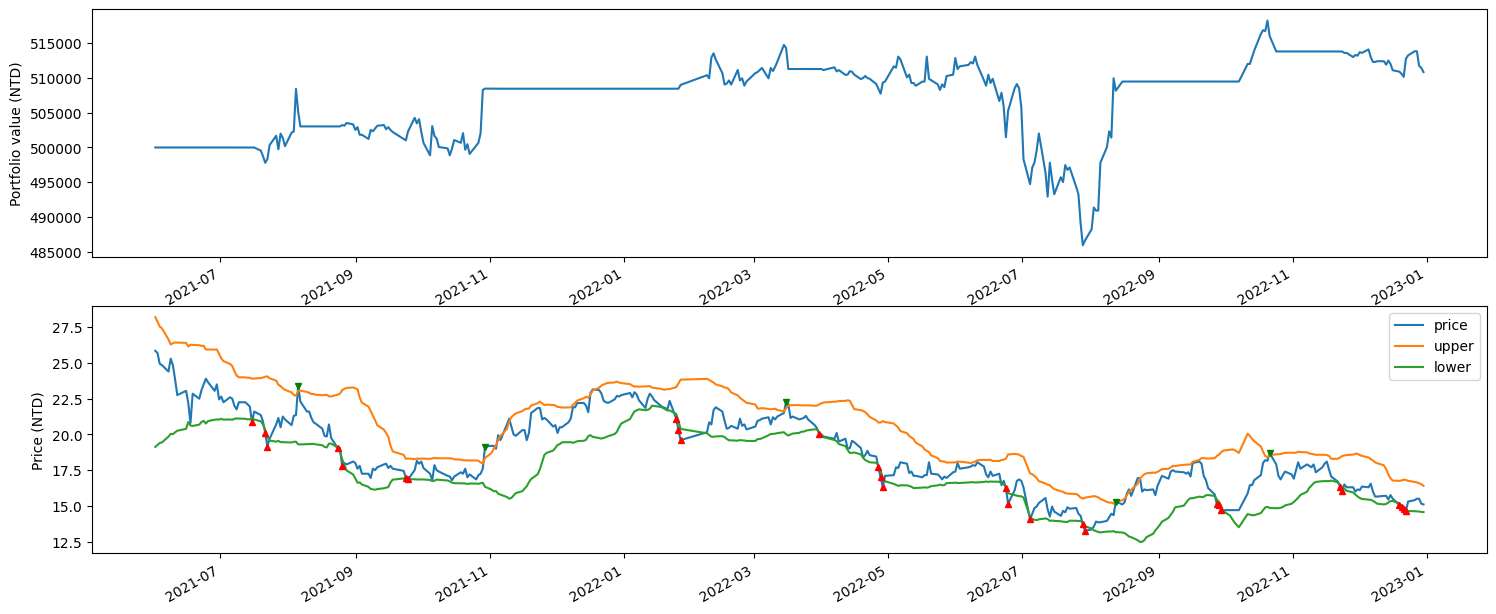

,period_open,period_close,positions,shorts_count,long_value,returns,short_value,ending_exposure,long_exposure,starting_exposure,...,sharpe,sortino,benchmark_period_return,excess_return,benchmark_volatility,max_drawdown,max_leverage,trading_days,period_label,treasury_period_return
2021-06-01 13:30:00+08:00,2021-06-01 09:01:00+08:00,2021-06-01 13:30:00+08:00,[],0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,-0.005791,0.005791,NaN,0.000000,0.000000,1,2021-06,0.0
2021-06-02 13:30:00+08:00,2021-06-02 09:01:00+08:00,2021-06-02 13:30:00+08:00,[],0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,-0.034823,0.034823,0.262782,0.000000,0.000000,2,2021-06,0.0
2021-06-03 13:30:00+08:00,2021-06-03 09:01:00+08:00,2021-06-03 13:30:00+08:00,[],0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,-0.038671,0.038671,0.223289,0.000000,0.000000,3,2021-06,0.0
2021-06-04 13:30:00+08:00,2021-06-04 09:01:00+08:00,2021-06-04 13:30:00+08:00,[],0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,-0.056082,0.056082,0.186788,0.000000,0.000000,4,2021-06,0.0
2021-06-07 13:30:00+08:00,2021-06-07 09:01:00+08:00,2021-06-07 13:30:00+08:00,[],0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,-0.021259,0.021259,0.397626,0.000000,0.000000,5,2021-06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26 13:30:00+08:00,2022-12-26 09:01:00+08:00,2022-12-26 13:30:00+08:00,"[{'sid': Equity(0 [2409]), 'amount': 6000, 'co...",0,93000.0,0.001169,0.0,93000.0,93000.0,92400.0,...,0.420172,0.647045,-0.397590,0.425293,0.413922,-0.056005,0.270017,391,2022-12,0.0
2022-12-27 13:30:00+08:00,2022-12-27 09:01:00+08:00,2022-12-27 13:30:00+08:00,"[{'sid': Equity(0 [2409]), 'amount': 6000, 'co...",0,93000.0,0.000000,0.0,93000.0,93000.0,93000.0,...,0.419636,0.646220,-0.397590,0.425293,0.413393,-0.056005,0.270017,392,2022-12,0.0
2022-12-28 13:30:00+08:00,2022-12-28 09:01:00+08:00,2022-12-28 13:30:00+08:00,"[{'sid': Equity(0 [2409]), 'amount': 6000, 'co...",0,90900.0,-0.004087,0.0,90900.0,90900.0,93000.0,...,0.358691,0.550359,-0.411193,0.434696,0.413228,-0.056005,0.270017,393,2022-12,0.0
2022-12-29 13:30:00+08:00,2022-12-29 09:01:00+08:00,2022-12-29 13:30:00+08:00,"[{'sid': Equity(0 [2409]), 'amount': 6000, 'co...",0,90600.0,-0.000586,0.0,90600.0,90600.0,90900.0,...,0.349728,0.536571,-0.413136,0.436039,0.412706,-0.056005,0.270017,394,2022-12,0.0


In [7]:
results = run_algorithm(
    start = pd.Timestamp('2021-06-01', tz='UTC'),
    end = pd.Timestamp('2022-12-31', tz ='UTC'),
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=5e5,
    handle_data = handle_data
)

results

## 績效評估

使用 `extract_rets_pos_txn_from_zipline()` 計算報酬、部位與交易紀錄。

In [8]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

### 報酬紀錄

In [9]:
returns.tail()

2022-12-26 00:00:00+00:00    0.001169
2022-12-27 00:00:00+00:00    0.000000
2022-12-28 00:00:00+00:00   -0.004087
2022-12-29 00:00:00+00:00   -0.000586
2022-12-30 00:00:00+00:00   -0.001173
Name: returns, dtype: float64

### 部位紀錄

In [10]:
positions.head()

sid,Equity(0 [2409]),cash
index,,
2021-07-16 00:00:00+00:00,21350.0,478647.15
2021-07-19 00:00:00+00:00,20900.0,478647.15
2021-07-20 00:00:00+00:00,20100.0,478647.15
2021-07-21 00:00:00+00:00,19150.0,478647.15
2021-07-22 00:00:00+00:00,39400.0,458944.30


### 交易紀錄

In [11]:
transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2021-07-16 05:30:00+00:00,Equity(0 [2409]),Equity(0 [2409]),21.35,a9664465c62b48c9b2be0f059620d1e5,1000,None,2021-07-16 13:30:00+08:00,-21350.000000
2021-07-22 05:30:00+00:00,Equity(0 [2409]),Equity(0 [2409]),19.70,c0cd13a325f846d2aee3ed09fe88f554,1000,None,2021-07-22 13:30:00+08:00,-19700.000000
2021-07-23 05:30:00+00:00,Equity(0 [2409]),Equity(0 [2409]),20.70,ee53128741e44b6089ac5a342713a8df,1000,None,2021-07-23 13:30:00+08:00,-20700.000000
2021-08-06 05:30:00+00:00,Equity(0 [2409]),Equity(0 [2409]),21.60,680e5c45e8c948a8998c0b1defbb5aac,-3000,None,2021-08-06 13:30:00+08:00,64799.999998
2021-08-24 05:30:00+00:00,Equity(0 [2409]),Equity(0 [2409]),17.80,c334592463f34ad9b9dac1f4aa91862b,1000,None,2021-08-24 13:30:00+08:00,-17800.000000


### 繪製基準 (benchmark) 與投組累積報酬率

使用 `plot_rolling_returns()` 繪製，本案例的基準為友達買入持有。

In [12]:
benchmark_rets = results['benchmark_return'] 

### 製作績效表

In [13]:
perf_stats = pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2021-06-01
End date,2022-12-30
Total months,18
,Backtest
Annual return,1.379%
Cumulative returns,2.17%
Annual volatility,4.415%
Sharpe ratio,0.33
Calmar ratio,0.25
Stability,0.26
Max drawdown,-5.6%
